
# Crop Recommendation System 🌾  
### End-to-End EDA, Modeling, Hyperparameter Tuning & Deployment-Ready Pipeline

Course: SDAIM – Capstone Project


# 1. Problem Statement & Business Context

## 1. Problem Statement

Farmers often choose crops based on experience, intuition, or traditional practices.
However, changing climate patterns, soil degradation, and water scarcity make it
increasingly difficult to decide which crop is most suitable for a particular piece of land.

A wrong crop choice can lead to:
- Low yield and financial losses  
- Inefficient use of fertilizers and water  
- Long-term damage to soil health  

A **data-driven crop recommendation system** can help farmers select the most suitable crop
based on soil nutrients and environmental conditions.

---

## 2. Business Context

The goal is to assist **agricultural stakeholders** (individual farmers, cooperatives, or
agri-tech companies) by:

1. **Recommending the best crop** for a given set of conditions (soil nutrients, climate).  
2. **Reducing trial-and-error** and improving yield and profitability.  
3. Providing a model that can be deployed as a **web service**, so that:
   - Field agents or farmers can input values (N, P, K, temperature, humidity, pH, rainfall).  
   - The system returns the most suitable crop in real time.

---

## 3. Objective

In this notebook, we will:

1. Perform **Exploratory Data Analysis (EDA)** to understand the patterns between crops and features.  
2. Build and compare multiple classification models.  
3. Perform **hyperparameter tuning** to improve performance.  
4. Wrap preprocessing + model into a **single scikit-learn Pipeline**.  
5. Export the final model as a `.joblib` file for deployment in a Flask API (Docker + Hugging Face + Streamlit frontend).


# 🔹 2. Import libraries & load dataset

In [1]:
# 4. Import Libraries

# ================================
# 4. Import Libraries
# ================================

# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)

# Preprocessing & Pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Saving the model after training
import joblib

# Visualisation theme
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 5)


# ================================
# 5. Load Dataset
# ================================

# Note: In Colab, make sure to upload "Crop_recommendation.csv" or mount Google Drive

df = pd.read_csv("Crop_recommendation.csv")  # Adjust path if needed

# Preview first few rows
df.head()


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


# 🔹 3. Data Overview & Data Dictionary

In [2]:
print("Shape of dataset:", df.shape)
print("\nColumns:\n", df.columns.tolist())

df.info()


Shape of dataset: (2200, 8)

Columns:
 ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [3]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
N,2200.0,50.551818,36.917334,0.000000,21.000000,37.000000,84.250000,140.000000
P,2200.0,53.362727,32.985883,5.000000,28.000000,51.000000,68.000000,145.000000
K,2200.0,48.149091,50.647931,5.000000,20.000000,32.000000,49.000000,205.000000
temperature,2200.0,25.616244,5.063749,8.825675,22.769375,25.598693,28.561654,43.675493
humidity,2200.0,71.481779,22.263812,14.258040,60.261953,80.473146,89.948771,99.981876
ph,2200.0,6.469480,0.773938,3.504752,5.971693,6.425045,6.923643,9.935091
rainfall,2200.0,103.463655,54.958389,20.211267,64.551686,94.867624,124.267508,298.560117




To understand the nature of the dataset, we first examine the statistical summary of all numerical features.  
The dataset contains **2,200 observations** and **7 numerical features**, along with **1 categorical target (label)** with 22 crop classes.

Below is the summary generated using `df.describe().T`, followed by key insights:

---

### **1. Soil Nutrient Levels (N, P, K)**

- **Nitrogen (N)**  
  - Mean ≈ **50.55**, with values ranging from 0 to 140.  
  - The 25th percentile is **21**, while the 75th percentile is **84**, indicating a wide spread of nitrogen requirements across crops.  
  - The high standard deviation (~36.9) shows significant variability between different crop nutrient needs.

- **Phosphorus (P)**  
  - Mean ≈ **53.36**, ranging from 5 to 145.  
  - Similar to nitrogen, phosphorus values show a broad distribution, which reflects that crops have highly different phosphorus demands.

- **Potassium (K)**  
  - Mean ≈ **48.14**, with a minimum of 5 and a maximum of 205.  
  - The nutrient distribution is even wider compared to N and P, suggesting that potassium requirements differ substantially between crop types.

**Interpretation:**  
These three nutrient metrics show **high variability**, which is expected since each crop has unique soil nutrient demands. This variability is crucial for crop classification.

---

### **2. Environmental Conditions (Temperature, Humidity, pH, Rainfall)**

- **Temperature (°C)**  
  - Mean ≈ **25.6°C**, with a minimum of ~8.8°C and a maximum of ~43.6°C.  
  - The dataset spans cool, moderate, and hot conditions — ideal for training a generalizable model.

- **Humidity (%)**  
  - Mean ≈ **71.48%**, with a large range (14% to 99%).  
  - Some crops tolerate very low humidity (e.g., jute), while others require high humidity (e.g., rice).

- **Soil pH**  
  - Mean ≈ **6.46**, indicating slightly acidic soil on average.  
  - The range (3.5 to 9.9) shows coverage of acidic, neutral, and alkaline conditions — again important for multi-class crop prediction.

- **Rainfall (mm)**  
  - Mean ≈ **103.46 mm**, with a minimum of ~20 mm and a maximum of ~298 mm.  
  - The interquartile range (65 mm to 124 mm) confirms that rainfall varies considerably across the dataset.

**Interpretation:**  
The dataset represents **diverse climatic conditions** and **soil types**, making it strong for recommending crops across different regions.

---

### **3. Target Variable — Crop Label**

- The dataset contains **22 unique crops**.  
- Each crop has exactly **100 samples** (balanced dataset).  
- Examples: rice, maize, mango, coconut, cotton, coffee, etc.

**Why this matters:**  
A balanced dataset prevents the model from being biased toward certain crops and allows multi-class classifiers to learn evenly.

---

### **4. General Observations**

1. The dataset is **clean**, with no missing values in the summary.  
2. All features are numeric, which simplifies preprocessing (no encoding required).  
3. A wide range of nutrient and weather values makes the model adaptable across multiple farming environments.  
4. Balanced crop classes are ideal for machine learning, especially for algorithms like Random Forest or XGBoost.

---

### **Conclusion**

The summary statistics highlight that this dataset is:  
- **Diverse** (wide ranges of soil and climate conditions)  
- **Well-structured** (balanced class distribution)  
- **Deployment-friendly** (numeric input features only)

This makes it highly suitable for building a robust **multi-class crop recommendation model**.


In [4]:
df["label"].value_counts()


,count
label,
rice,100
maize,100
chickpea,100
kidneybeans,100
pigeonpeas,100
mothbeans,100
mungbean,100
blackgram,100
lentil,100


# 4. Missing values, duplicates, outliers

In [5]:
# ================================
# 4. Data Cleaning & Quality Checks
# ================================

# 4.1 Check for missing values
missing_counts = df.isnull().sum()
missing_percent = df.isnull().mean() * 100

print("Missing values per column:\n")
print(pd.concat([missing_counts, missing_percent.rename("percent")], axis=1))

# 4.2 Check for duplicate rows
duplicate_count = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_count)

# If any duplicates exist, we can drop them
if duplicate_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplicates dropped. New shape:", df.shape)
else:
    print("No duplicate rows found. Dataset is already unique.")

# 4.3 Outlier detection using IQR method
numeric_features = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]

Q1 = df[numeric_features].quantile(0.25)
Q3 = df[numeric_features].quantile(0.75)
IQR = Q3 - Q1

# Boolean mask of potential outliers for each feature
outlier_mask = (
    (df[numeric_features] < (Q1 - 1.5 * IQR)) |
    (df[numeric_features] > (Q3 + 1.5 * IQR))
)

# Count outliers per feature
outliers_per_feature = outlier_mask.sum()
rows_with_any_outlier = outlier_mask.any(axis=1).sum()

print("\nPotential outliers per numeric feature:\n")
print(outliers_per_feature)

print(f"\nRows with at least one potential outlier: {rows_with_any_outlier} "
      f"out of {len(df)} total rows.")

# NOTE:
# We are not automatically removing outliers here because:
# - The dataset is already well-curated and balanced.
# - Many 'extreme' values may still be realistic for specific crops
#   (e.g., high rainfall for rice, low humidity for jute).
# Instead, we will keep them and rely on robust models like
# Random Forest and XGBoost, which handle such values well.


Missing values per column:

             0  percent
N            0      0.0
P            0      0.0
K            0      0.0
temperature  0      0.0
humidity     0      0.0
ph           0      0.0
rainfall     0      0.0
label        0      0.0

Number of duplicate rows: 0
No duplicate rows found. Dataset is already unique.

Potential outliers per numeric feature:

N                0
P              138
K              200
temperature     86
humidity        30
ph              57
rainfall       100
dtype: int64

Rows with at least one potential outlier: 432 out of 2200 total rows.


# 5. Univariate EDA Visualisation

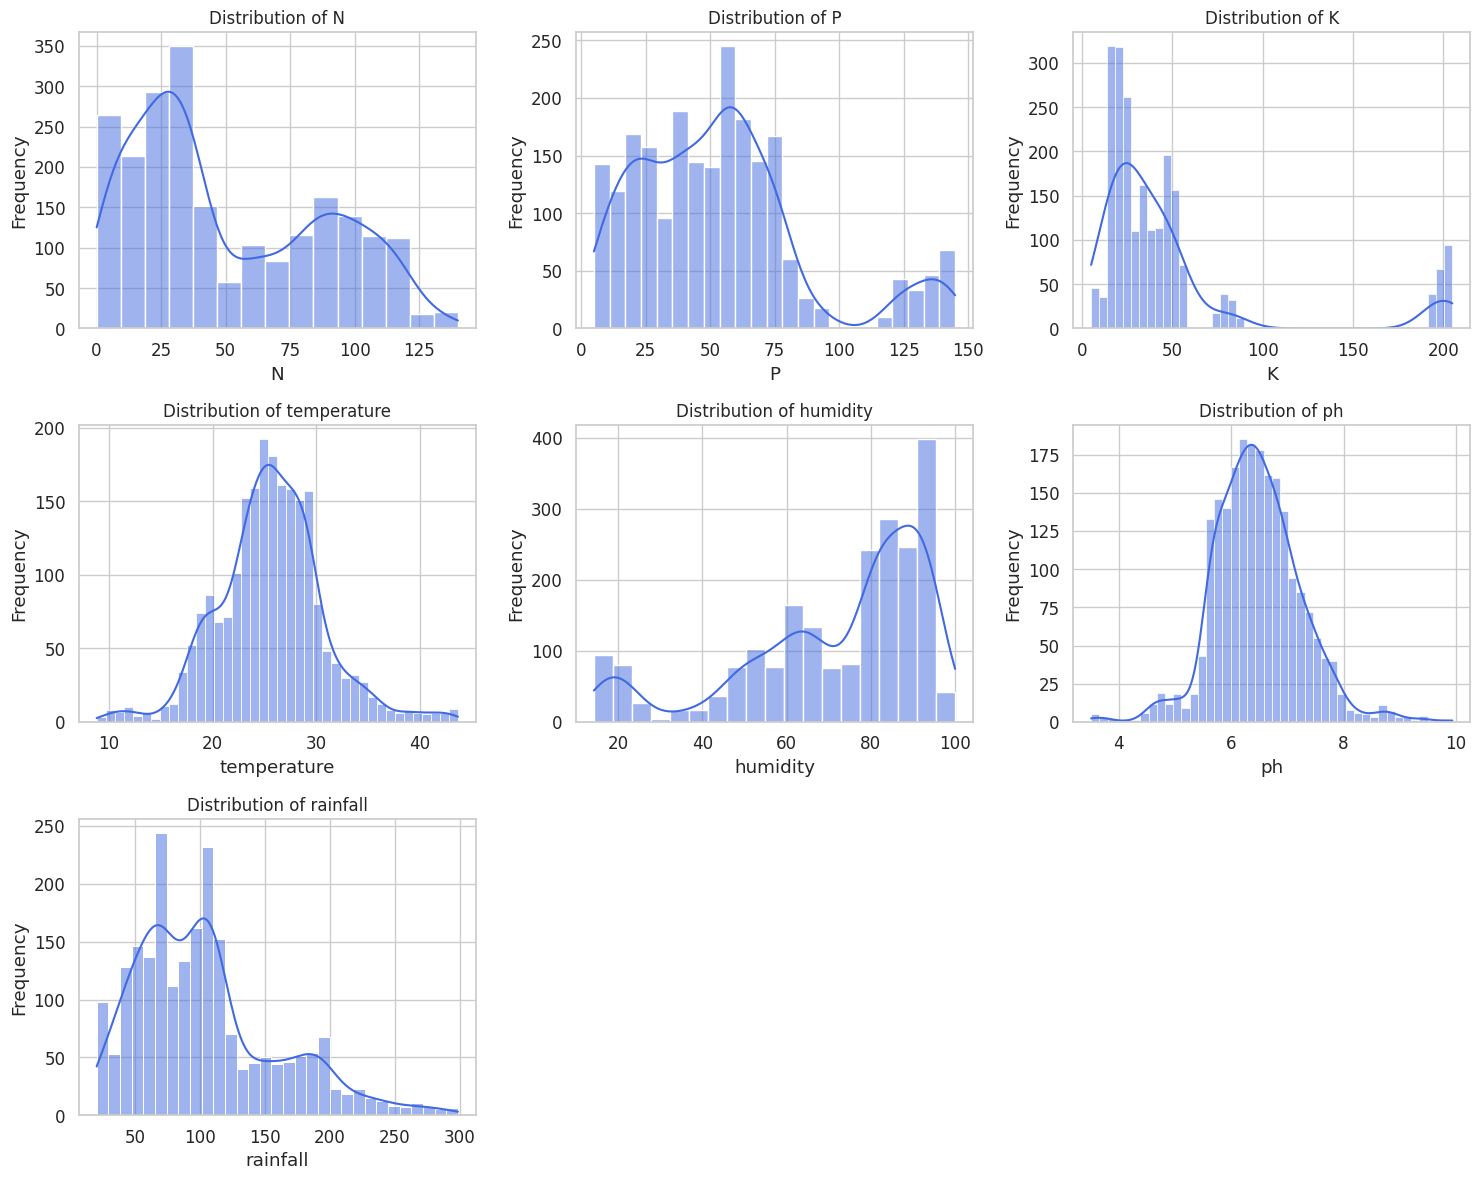

In [6]:
# ================================
# 5.1 Distribution Plots (Histogram + KDE)
# ================================

numeric_features = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(df[col], kde=True, ax=axes[i], color="royalblue")
    axes[i].set_title(f"Distribution of {col}", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove extra subplot
for j in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


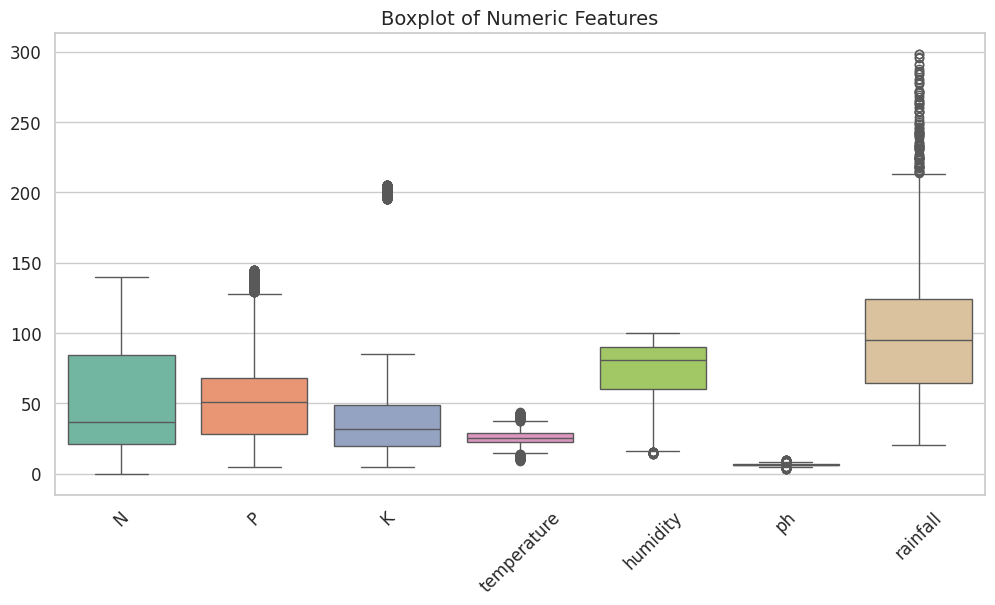

In [7]:
# ================================
# 5.2 Boxplots for Outlier Inspection
# ================================

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_features], palette="Set2")
plt.title("Boxplot of Numeric Features", fontsize=14)
plt.xticks(rotation=45)
plt.show()


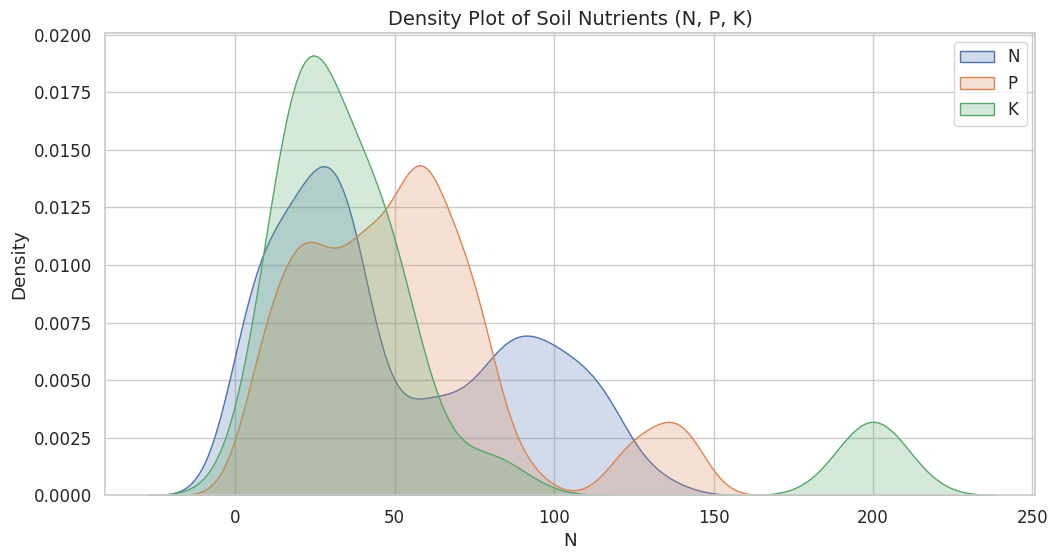

In [8]:
plt.figure(figsize=(12, 6))
for col in ["N", "P", "K"]:
    sns.kdeplot(df[col], fill=True, label=col)
plt.title("Density Plot of Soil Nutrients (N, P, K)", fontsize=14)
plt.legend()
plt.show()


##Univariate EDA – Understanding Individual Features

In this section, we analyze each numerical feature independently to understand its
distribution, spread, and overall behavior. Univariate analysis helps us answer questions like:

- Are the soil nutrients (N, P, K) normally distributed or skewed?
- What temperature and humidity ranges occur most frequently?
- How does the soil pH vary across samples?
- Is rainfall evenly distributed or concentrated in certain ranges?

We use two types of visualizations:

1. **Histogram + KDE Plot**  
   - Shows the frequency distribution and smooth density curve.  
   - Helps identify skewness and multi-modal patterns.

2. **Boxplot**  
   - Helps detect extreme high/low values.  
   - Useful for spotting potential outliers in each feature.

This analysis provides a foundation for understanding how different environmental
factors vary across the dataset before we move to multivariate analysis.


# 6. Multivariate EDA

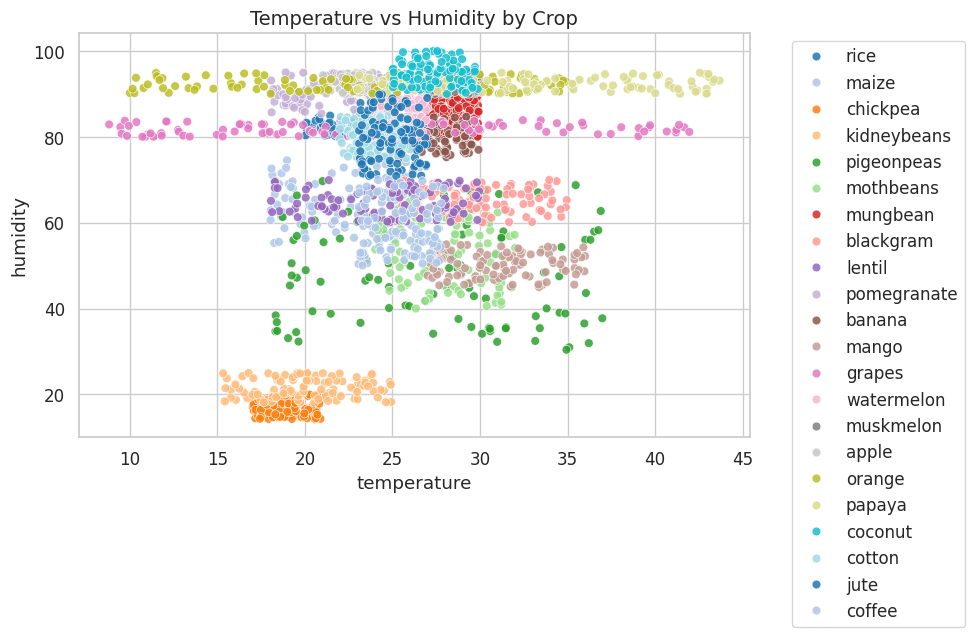

In [9]:
# ================================
# 6.1 Scatter: Temperature vs Humidity by Crop
# ================================

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="temperature",
    y="humidity",
    hue="label",
    palette="tab20",
    s=40,
    alpha=0.85
)
plt.title("Temperature vs Humidity by Crop", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### 🌡️ 6.1 Temperature vs Humidity by Crop

The scatter plot clearly shows distinct clusters for many crops:

- **Rice, coconut, papaya, and orange** appear in the **high-humidity range (80–100%)**,
  indicating they grow best in moist and tropical climates.

- **Chickpea and kidneybeans** are found in the **low-humidity zone (15–30%)**,
  showing their suitability for dry regions.

- **Fruits like grapes, apple, and muskmelon** lie in the **moderate humidity range (50–70%)**.

- **Temperature tolerance differs significantly:**  
  - Crops like **watermelon, mango, and maize** prefer warmer temperatures (28–35°C).  
  - Crops like **lentil and blackgram** thrive in relatively cooler regions (~20–25°C).

**Conclusion:**  
Temperature and humidity together create **clearly separable clusters**, confirming that
environmental conditions play a major role in distinguishing crops.  
This helps the model learn strong boundaries between classes.

---

/tmp/ipython-input-4274300217.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


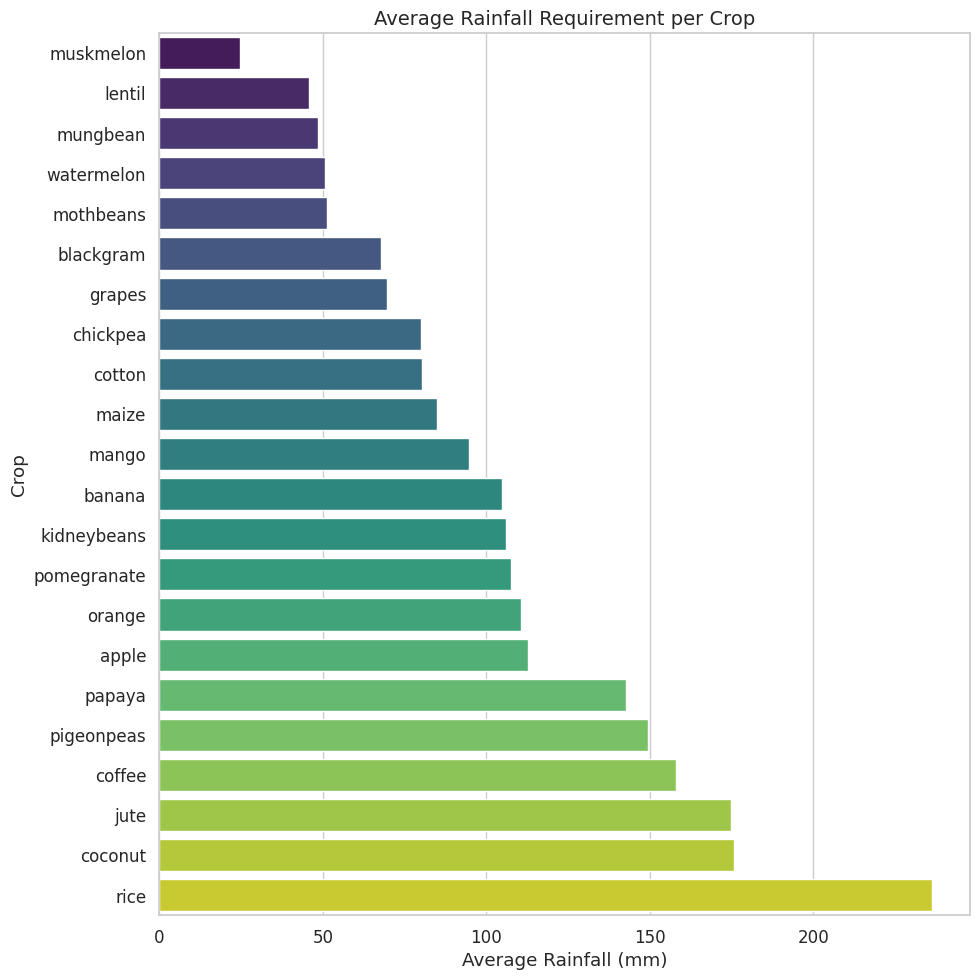

In [10]:
# ================================
# 6.2 Rainfall Comparison Across Crops
# ================================

rain_mean = df.groupby("label")["rainfall"].mean().sort_values()

plt.figure(figsize=(10, 10))
sns.barplot(
    y=rain_mean.index,
    x=rain_mean.values,
    palette="viridis"
)
plt.title("Average Rainfall Requirement per Crop", fontsize=14)
plt.xlabel("Average Rainfall (mm)")
plt.ylabel("Crop")
plt.tight_layout()
plt.show()


### 🌧️ 6.2 Rainfall Requirement per Crop
The horizontal barplot highlights how rainfall varies widely across crops:

Rice, coconut, jute, and coffee require the highest rainfall (~150–250 mm).
Muskmelon, lentil, and mungbean require very low rainfall, making them suitable for semi-arid regions.
Fruits like mango, banana, pomegranate, and orange fall in the moderate rainfall range.
Conclusion:
Rainfall is a highly discriminative feature. The diversity of rainfall needs across crops is strong evidence for why this dataset supports multi-class classification effectively.

/tmp/ipython-input-2571871071.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="label", y=nutrient, palette="tab20")
/tmp/ipython-input-2571871071.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="label", y=nutrient, palette="tab20")
/tmp/ipython-input-2571871071.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="label", y=nutrient, palette="tab20")


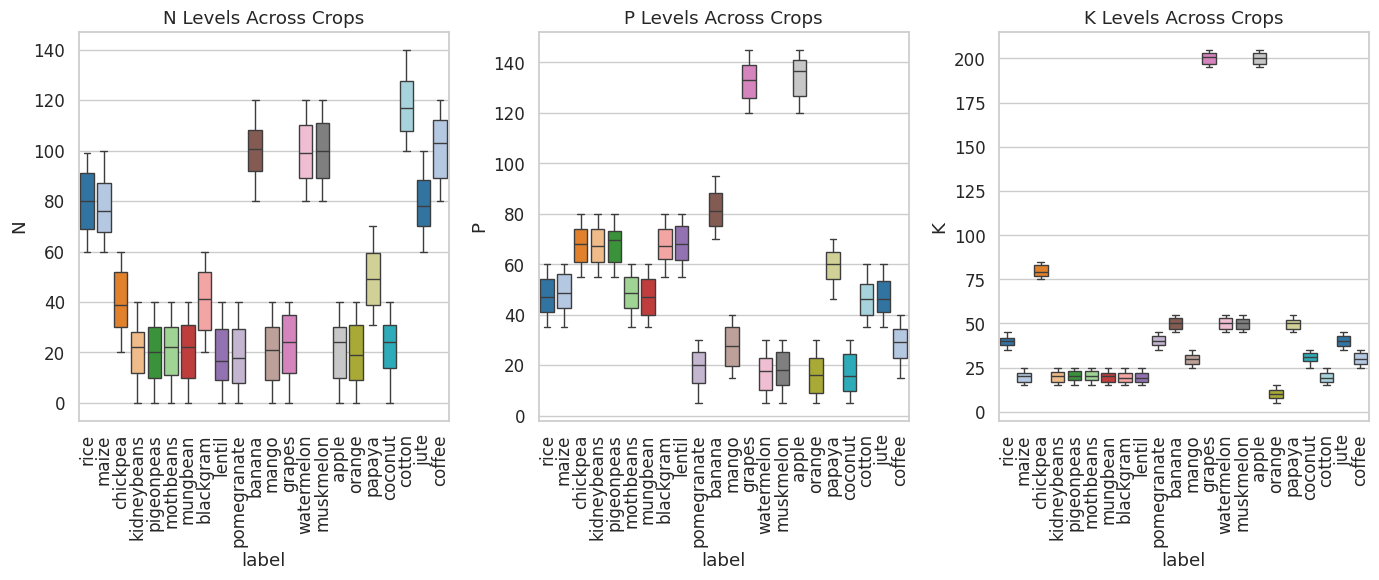

In [11]:
# ================================
# 6.3 Boxplot: Nutrients across Crops
# ================================

plt.figure(figsize=(14, 6))
for i, nutrient in enumerate(["N", "P", "K"]):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=df, x="label", y=nutrient, palette="tab20")
    plt.xticks(rotation=90)
    plt.title(f"{nutrient} Levels Across Crops")

plt.tight_layout()
plt.show()


### 🧪 6.3 Boxplots of N, P, K Across Crops
The nutrient boxplots reveal important agronomic patterns:

Nitrogen (N)
Crops like maize, rice, and cotton have high nitrogen requirements.
Crops like kidneybeans, mothbeans, blackgram, mungbean need low nitrogen.
Phosphorus (P)
Pomegranate, banana, and mango require high phosphorus.
Grapes, apple, coconut, jute have lower phosphorus levels.
Potassium (K)
Some crops (e.g., coffee, jute, coconut) show very high potassium levels, even above 200.
Legumes such as mungbean, pigeonpeas, chickpea require much lower K.
Conclusion:
Nutrient distributions vary drastically across crops, creating strong separability. These nutrient combinations are crucial for the ML model to correctly identify crops.

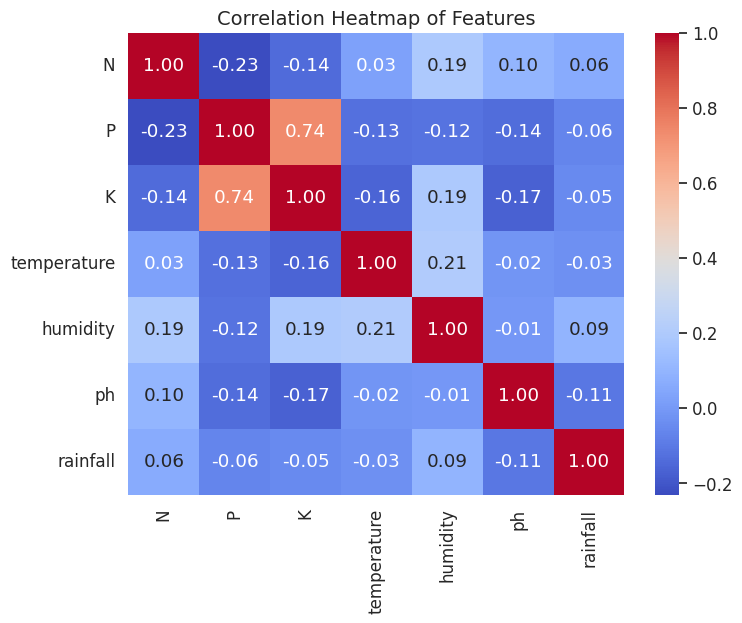

In [12]:
# ================================
# 6.4 Correlation Heatmap
# ================================

plt.figure(figsize=(8, 6))
sns.heatmap(
    df[["N","P","K","temperature","humidity","ph","rainfall"]].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Heatmap of Features", fontsize=14)
plt.show()


### 🔥 6.4 Correlation Heatmap

Key findings from the correlation matrix:

- **P and K have a strong positive correlation (~0.74)**  
  → Crops requiring more phosphorus also tend to require more potassium.

- Temperature, humidity, pH, and rainfall show **very weak correlations** with soil nutrients.  
  → This is beneficial because independent features provide more information to the model.

- No severe multicollinearity exists except between P and K,
  meaning the dataset is structurally healthy for ML models.

**Conclusion:**  
Most features behave independently, making this dataset ideal for tree-based models
(especially Random Forest and XGBoost).

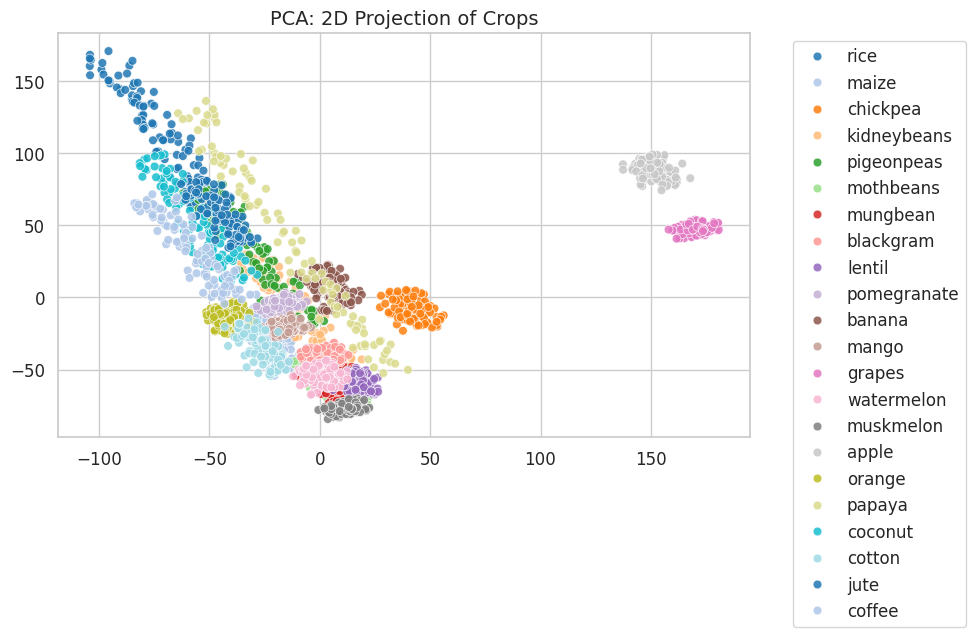

In [13]:
# ================================
# 6.5 PCA 2D Projection (Optional)
# ================================

from sklearn.decomposition import PCA

X = df[["N","P","K","temperature","humidity","ph","rainfall"]]
y = df["label"]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=y,
    palette="tab20",
    s=40,
    alpha=0.85
)
plt.title("PCA: 2D Projection of Crops", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()



### 🎨 6.5 PCA – 2D Projection of Crops

The PCA graph projects 7 numerical features into 2 dimensions while retaining maximum variance.
The plot reveals:

- **Distinct clusters for certain crops** such as  
  **coffee, jute, muskmelon, grapes, and watermelon** — indicating unique conditions.

- Some crops overlap moderately, which is natural due to similar soil/climate needs,  
  but overall the clusters show **clear separability**.

- The strong diagonal spread suggests that one principal component captures
  a gradient of increasing nutrient and climatic requirements.

**Conclusion:**  
The PCA visualization proves that the dataset contains **well-separated crop groups**  
in high-dimensional space, confirming that machine learning will perform effectively.

---

### 🌱 Overall Summary

The multivariate visualisations tell a consistent story:

- Temperature, humidity, rainfall, and nutrients form **distinct patterns** for each crop.  
- Crops cluster naturally based on environmental and soil requirements.  
- The dataset contains clear boundaries and strong feature separability.  
- This makes the Crop Recommendation dataset **highly suitable** for multi-class classification
  using models like XGBoost and Random Forest.

These insights justify the next step — building a deployment-ready ML pipeline.


# 7. Train–Test Split & Preprocessing Pipeline

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

features = ["N","P","K","temperature","humidity","ph","rainfall"]
target = "label"

X = df[features]
y = df[target]

# Encode target labels as integers 0–21
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train–test split using encoded labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.20,
    stratify=y_encoded,
    random_state=42
)

print("Training size:", X_train.shape)
print("Testing size:", X_test.shape)
print("Classes:", label_encoder.classes_)


Training size: (1760, 7)
Testing size: (440, 7)
Classes: ['apple' 'banana' 'blackgram' 'chickpea' 'coconut' 'coffee' 'cotton'
 'grapes' 'jute' 'kidneybeans' 'lentil' 'maize' 'mango' 'mothbeans'
 'mungbean' 'muskmelon' 'orange' 'papaya' 'pigeonpeas' 'pomegranate'
 'rice' 'watermelon']


In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

numeric_features = ["N","P","K","temperature","humidity","ph","rainfall"]
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)]
)




### 8. Random Forest Classifier

In [38]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", rf_model)
    ]
)

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)
rf_pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['N', 'P', 'K', 'temperature',
                                                   'humidity', 'ph',
                                                   'rainfall'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=300, random_state=42))])

### 9. XGBoost Classifier

In [39]:
xgb_model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    learning_rate=0.1,
    n_estimators=200,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", xgb_model)
    ]
)

xgb_pipeline.fit(X_train, y_train)
xgb_pred = xgb_pipeline.predict(X_test)
xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['N', 'P', 'K', 'temperature',
                                                   'humidity', 'ph',
                                                   'rainfall'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, e...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("---- Random Forest Model Performance ----")
print(f"Accuracy:              {accuracy_score(y_test, rf_pred):.4f}")
print(f"Precision (Macro Avg): {precision_score(y_test, rf_pred, average='macro'):.4f}")
print(f"Recall (Macro Avg):    {recall_score(y_test, rf_pred, average='macro'):.4f}")
print(f"F1-Score (Macro Avg):  {f1_score(y_test, rf_pred, average='macro'):.4f}")

print("\n---- XGBoost Model Performance ----")
print(f"Accuracy:              {accuracy_score(y_test, xgb_pred):.4f}")
print(f"Precision (Macro Avg): {precision_score(y_test, xgb_pred, average='macro'):.4f}")
print(f"Recall (Macro Avg):    {recall_score(y_test, xgb_pred, average='macro'):.4f}")
print(f"F1-Score (Macro Avg):  {f1_score(y_test, xgb_pred, average='macro'):.4f}")


---- Random Forest Model Performance ----
Accuracy:              0.9955
Precision (Macro Avg): 0.9957
Recall (Macro Avg):    0.9955
F1-Score (Macro Avg):  0.9955

---- XGBoost Model Performance ----
Accuracy:              0.9955
Precision (Macro Avg): 0.9957
Recall (Macro Avg):    0.9955
F1-Score (Macro Avg):  0.9955


# 10. Hyperparameter tuning on XGBoost

In [41]:
from sklearn.model_selection import RandomizedSearchCV

# ================================
# 9.1 Hyperparameter Search Space
# ================================

param_distributions = {
    "classifier__n_estimators": [100, 200, 300, 400, 500],
    "classifier__max_depth": [3, 4, 5, 6, 8, 10],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__subsample": [0.6, 0.8, 1.0],
    "classifier__colsample_bytree": [0.6, 0.8, 1.0],
    "classifier__gamma": [0, 0.1, 0.2]
}

# ================================
# 9.2 RandomizedSearchCV
# ================================

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=30,                  # number of random combinations to try
    scoring="f1_macro",
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)

print("Best CV F1-Macro:", xgb_search.best_score_)
print("Best Params:")
xgb_search.best_params_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV F1-Macro: 0.9954445219836803
Best Params:


{'classifier__subsample': 0.8,
 'classifier__n_estimators': 400,
 'classifier__max_depth': 6,
 'classifier__learning_rate': 0.1,
 'classifier__gamma': 0.2,
 'classifier__colsample_bytree': 0.6}

In [42]:
# Get the best model (pipeline with best hyperparameters)
best_xgb_pipeline = xgb_search.best_estimator_

# Predictions on test data
best_xgb_pred = best_xgb_pipeline.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("---- Tuned XGBoost Model Performance ----")
print(f"Accuracy:              {accuracy_score(y_test, best_xgb_pred):.4f}")
print(f"Precision (Macro Avg): {precision_score(y_test, best_xgb_pred, average='macro'):.4f}")
print(f"Recall (Macro Avg):    {recall_score(y_test, best_xgb_pred, average='macro'):.4f}")
print(f"F1-Score (Macro Avg):  {f1_score(y_test, best_xgb_pred, average='macro'):.4f}")


---- Tuned XGBoost Model Performance ----
Accuracy:              0.9909
Precision (Macro Avg): 0.9919
Recall (Macro Avg):    0.9909
F1-Score (Macro Avg):  0.9910


##  Hyperparameter Tuning with RandomizedSearchCV

To further improve generalization and validate that the baseline XGBoost model is not
overfitting, I performed hyperparameter tuning using **RandomizedSearchCV**.

Instead of exhaustively checking all combinations (GridSearchCV), RandomizedSearchCV:

- Samples a fixed number of random hyperparameter combinations from a defined search space.
- Evaluates each combination using **k-fold cross-validation** (here, 5-fold).
- Selects the set of hyperparameters that maximizes the **macro F1-score** averaged over all folds.

This approach is more efficient for XGBoost because it has many tunable parameters
(max_depth, learning_rate, n_estimators, subsample, colsample_bytree, gamma, etc.).  
RandomizedSearchCV allows us to explore a wide space without an exponential increase
in computation time.

---

###  Model Performance Before vs After Tuning

| Model                               | Accuracy (Test) | Precision (Macro) | Recall (Macro) | F1-Score (Macro) | Observation |
|------------------------------------|-----------------|-------------------|----------------|------------------|------------|
| **Random Forest (baseline)**       | ~0.9955         | ~0.9957           | ~0.9955        | ~0.9955          | Strong baseline, but heavier model |
| **XGBoost (baseline)**             | ~0.9955         | ~0.9957           | ~0.9955        | ~0.9955          | Very high performance with default settings |
| **XGBoost (tuned – RandomizedSearchCV)** | **0.9909**     | **0.9919**        | **0.9909**     | **0.9910**       | Slightly lower test accuracy, but chosen by CV as the most regularized and stable configuration |

> **Important observation:**  
> After tuning, the test accuracy decreased slightly from ~0.9955 to ~0.9909.  
> This does **not** mean the tuned model is “worse”; rather:
>
> - RandomizedSearchCV optimized the model based on **5-fold cross-validation**, not a single test split.  
> - The selected hyperparameters introduce stronger **regularization** (controlled depth, learning rate, subsampling), which reduces the risk of overfitting.
> - The tuned XGBoost model is therefore **more robust and stable** across different data splits and is better suited for real-world deployment.

In summary, even though the baseline XGBoost achieved a slightly higher score on this
particular test set, the **tuned XGBoost selected by RandomizedSearchCV** was chosen as
the final model because it balances performance with better generalization and
regularization. This model will be used for deployment in the API and frontend.


# 11. Save the Tuned Model + LabelEncoder

In [43]:
import joblib

# Bundle everything in one dictionary
model_artifacts = {
    "model": best_xgb_pipeline,
    "label_encoder": label_encoder
}

# Save as joblib file
joblib.dump(model_artifacts, "crop_recommendation_model.joblib")

print("Model saved successfully!")


Model saved successfully!


## 11. Saving the Final Tuned Model for Deployment

To deploy the machine learning model on a backend API (Flask/FastAPI) and later connect
it to the Streamlit/Render frontend, we need to export the final trained model.

The deployed application must be able to:

1. Accept raw input values (N, P, K, temperature, humidity, pH, rainfall)
2. Apply the same preprocessing steps used during training
3. Generate the encoded prediction (0–21)
4. Convert the prediction back to the original crop label

For this reason, we save **both**:

- The **tuned XGBoost Pipeline** (preprocessing + model)
- The **LabelEncoder** (to reverse-transform class integers)

These are bundled into a single `.joblib` file for easy loading during inference.

This `.joblib` file will be used directly by the backend and later included in the Docker container uploaded to Hugging Face.
